In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

2025-12-15 17:05:57.907721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:
df = pd.read_csv("../../data/FlunetData_United States of America_All Sites_for_28 October 2024 to 20 October 2025.csv")
df = df.sort_values("Week start date (ISO 8601 calendar)")
df = df[df["Surveillance site type"] == "Non-sentinel"]
df[:5]

,Unnamed: 0,Country area or territory,Surveillance site type,Year-week (ISO 8601 calendar),Week start date (ISO 8601 calendar),Specimen tested,Influenza positive,Influenza negative,A (H1N1)pdm09,A (H3),A (H5),A not subtyped,B (Victoria),B (lineage not determined)
0,1,United States of America,Non-sentinel,2024-44,2024-10-28,75257,917,74340,NaN,NaN,NaN,843,NaN,74
1,2,United States of America,Non-sentinel,2024-45,2024-11-04,76717,1172,75545,NaN,NaN,NaN,1088,NaN,84
2,3,United States of America,Non-sentinel,2024-46,2024-11-11,81959,1730,80229,NaN,NaN,NaN,1604,NaN,126
3,4,United States of America,Non-sentinel,2024-47,2024-11-18,86735,2458,84277,NaN,NaN,NaN,2291,NaN,167
4,5,United States of America,Non-sentinel,2024-48,2024-11-25,83810,3309,80501,NaN,NaN,NaN,3122,NaN,187


In [3]:

I_data = df["Influenza positive"].to_numpy()
I_data

array([  917,  1172,  1730,  2458,  3309,  5064,  9128, 17517, 23900,
       25274, 24600, 33734, 42608, 55042, 56036, 44722, 33909, 25963,
       18573, 14369, 10456,  8372,  6279,  4932,  3947,  3196,  2152,
        1459,  1151,   979,   883,   733,   511,   408,   298,   266,
         253,   142])

In [4]:
t_0, t_f = 0, len(I_data) - 1
N = 340000000 # population size

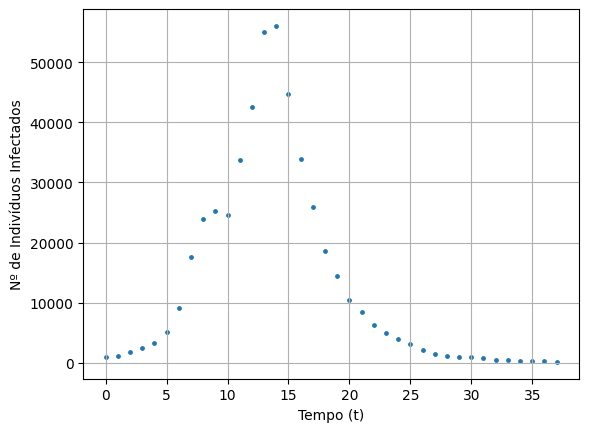

In [ ]:
plotting.plot_incidence_data(I_data, "data-eua-2025")

In [ ]:
model = WorkflowModel(t_0, t_f, I_data, data_t, N, 1/7, 
    activation="tanh",
    n_hidden_layers=3,
    hidden_layer_size=80, 
    scaling="min/max",
    adaptative_wdata=False,
    early_stopping=False)

[<deepxde.icbc.initial_conditions.IC object at 0x7f7ee13f2690>, <deepxde.icbc.initial_conditions.IC object at 0x7f7f2e496f50>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x7f7f2cc4b090>]
Compiling model...
'compile' took 0.006789 s



2025-12-15 17:06:01.385959: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1765829161.386698  916620 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2262 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
model.scaled_I_data

array([0.01386553, 0.01842774, 0.02841092, 0.04143557, 0.05666082,
       0.08805954, 0.1607686 , 0.31085626, 0.42505457, 0.44963681,
       0.43757827, 0.60099474, 0.75975954, 0.98221634, 1.        ,
       0.79758114, 0.60412567, 0.46196372, 0.32974917, 0.25453537,
       0.18452786, 0.147243  , 0.10979712, 0.08569793, 0.06807529,
       0.05463914, 0.03596093, 0.02356246, 0.01805203, 0.01497477,
       0.01325724, 0.01057359, 0.00660178, 0.00475901, 0.002791  ,
       0.00221848, 0.0019859 , 0.        ])

In [8]:
model.S0, model.I0, model.scaled_N

(np.float64(6082.926306938133),
 np.float64(0.013865531184026909),
 np.float64(6082.940172469317))

In [9]:
model.train()

Training model...



2025-12-15 17:06:03.397431: I external/local_xla/xla/service/service.cc:163] XLA service 0x5617a81ff670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 17:06:03.397447: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-15 17:06:03.415078: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-15 17:06:03.480485: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1765829163.757770  916620 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [1.17e-03, 3.81e-03, 3.70e+07, 1.92e-04, 1.21e-01]    [2.64e-04, 2.88e-03, 3.70e+07, 1.92e-04, 1.21e-01]    []  
100       [3.23e-05, 1.11e-04, 3.67e+07, 9.89e-03, 9.53e-02]    [3.10e-05, 1.11e-04, 3.67e+07, 9.89e-03, 9.53e-02]    []  
200       [9.80e-05, 4.97e-05, 3.64e+07, 1.11e-02, 9.40e-02]    [9.65e-05, 4.97e-05, 3.64e+07, 1.11e-02, 9.40e-02]    []  
300       [7.93e-05, 6.35e-05, 3.62e+07, 1.11e-02, 9.40e-02]    [7.85e-05, 6.35e-05, 3.62e+07, 1.11e-02, 9.40e-02]    []  
400       [7.36e-05, 6.75e-05, 3.60e+07, 1.11e-02, 9.40e-02]    [7.30e-05, 6.75e-05, 3.60e+07, 1.11e-02, 9.40e-02]    []  
500       [7.13e-05, 6.75e-05, 3.58e+07, 1.11e-02, 9.40e-02]    [7.08e-05, 6.75e-05, 3.58e+07, 1.11e-02, 9.40e-02]    []  
600       [7.11e-05, 6.29e-05, 3.57e+07, 1.11e-02, 9.39e-02]    [7.07e-05, 6.29e-05, 3.57e+07, 1.11e-02, 9.39e-02]    []  
700      

(<deepxde.model.LossHistory at 0x7f7ebd38c3d0>,
 <deepxde.model.TrainState at 0x7f7ebd38d090>)

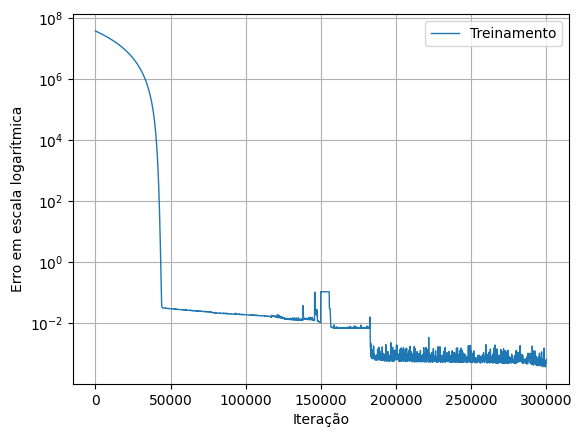

In [10]:
plotting.plot_losshistory(model.losshistory, "loss-eua-2025")

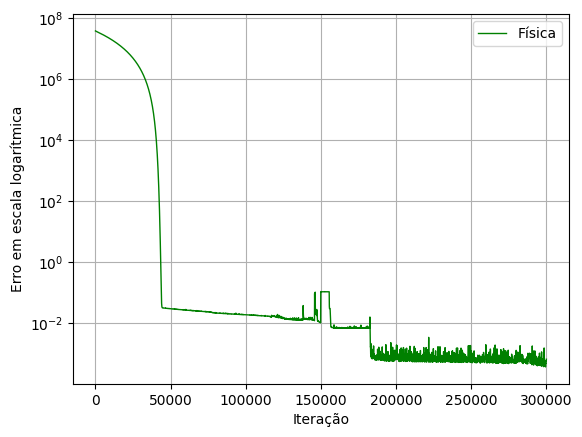

In [11]:
plotting.plot_phys_losshistory(model.losshistory, "loss-phys-eua-2025")

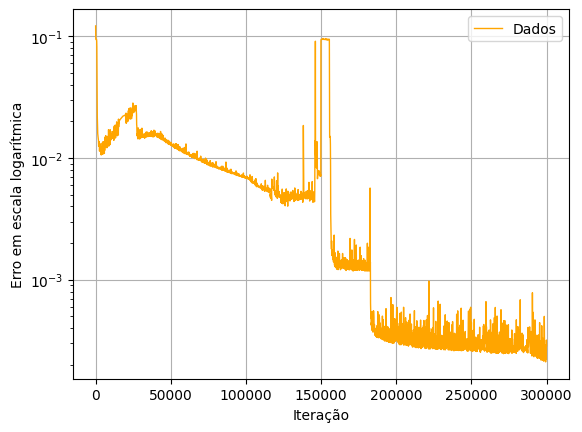

In [12]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-eua-2025")

In [13]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t)

In [14]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist, "wdados-eua-2025")

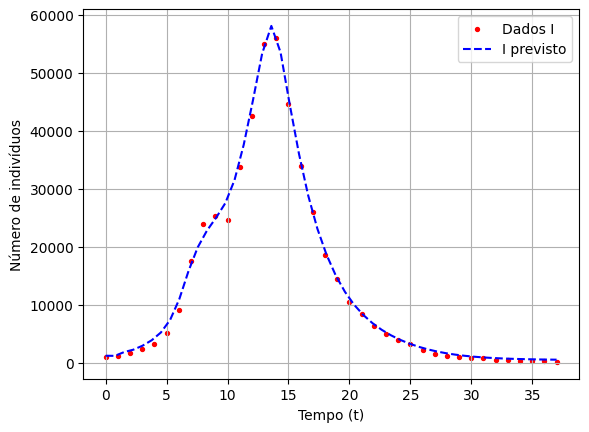

In [15]:
plotting.plot_incidence_results(I_data, data_t, pred[:,1:2], test_t, "incidence-results-eua-2025")

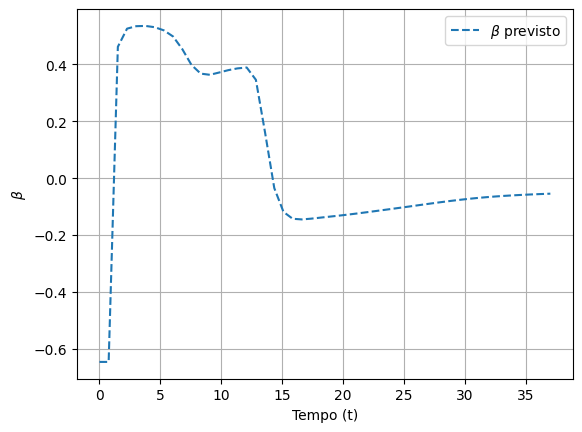

In [16]:
plotting.plot_beta(pred[:,2], test_t, "beta-eua-2025")

In [17]:
pred_eval = model.predict(data_t)
eval_predictions(I_data.reshape(-1,1), pred_eval[:,1].reshape(-1,1), ["I"])

,compartiment,MSE,L2,L-infinity
0,I,897314.96106,0.046119,3743.742039


In [ ]:
model.formated_total_training_time